## 2 - Exploring Titanic Data + Decision Trees

Load the data. This file is similar to the one from https://www.kaggle.com/c/titanic/data

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(12)

In [2]:
df = pd.read_csv('data.csv')

Examine the structure of the data.

In [3]:
df.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


### Features + Target
Our target label here is the column `Survived`. The other columns are features which may help us predict `Survived`.

Separate the features from the target label:

In [5]:
y = df.Survived
X = df.drop(['Survived'], axis=1)

# Check that our columns are correctly updated
assert 'Survived' in y.name
assert 'Survived' not in X.columns

### Split data into training and testing groups

We do this because when we build our model, we don't want it to see all the data. Otherwise we won't be able to judge whether our model can gereralize well. Similar to how your teacher trains you with questions and answers during lecture but at exam time only gives you the questions.

#### Method 1: Split the data into two groups: training + testing
<img src="train_test_split_matrix.svg">

```
df_train = df.iloc[:712, :]
df_test = df.iloc[712:, :]
```

Equivalently:

```
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
```

#### Method 2: Split the data into three groups: training + validation + testing
<img src="validation.svg">

First, split off training data:
```
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
```

Second, split test set into validation and test:
```
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5)
```

#### Method 3: Cross Validation
- A more complex version of Method 2

Method 2 and 3 are preferred because we don't want to use our test data until our model is complete. Otherwise we may overfit our model to the test data.

We will start with method 2.

In [6]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=10)

In [7]:
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(712, 11) (712,)
(89, 11) (89,)
(90, 11) (90,)


### Cleaning data

We need to correct for categorical data and missing data. First we drop columns which don't look useful.

In [8]:
x_train.head()

PassengerId  Pclass                                               Name  \
57            58       3                                Novel, Mr. Mansouer   
717          718       2                Troutt, Miss. Edwina Celia "Winnie"   
431          432       3  Thorneycroft, Mrs. Percival (Florence Kate White)   
633          634       1                      Parr, Mr. William Henry Marsh   
163          164       3                                    Calic, Mr. Jovo   

        Sex   Age  SibSp  Parch  Ticket     Fare Cabin Embarked  
57     male  28.5      0      0    2697   7.2292   NaN        C  
717  female  27.0      0      0   34218  10.5000  E101        S  
431  female   NaN      1      0  376564  16.1000   NaN        S  
633    male   NaN      0      0  112052   0.0000   NaN        S  
163    male  17.0      0      0  315093   8.6625   NaN        S

In [9]:
x_train = x_train.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 57 to 265
Data columns (total 7 columns):
Pclass      712 non-null int64
Sex         712 non-null object
Age         577 non-null float64
SibSp       712 non-null int64
Parch       712 non-null int64
Fare        712 non-null float64
Embarked    710 non-null object
dtypes: float64(2), int64(3), object(2)
memory usage: 44.5+ KB


We notice two things:
1. the columns `Age` and `Embarked` have `NaNs` or missing values. We need to fix these before we pass data to the classifier.
- the columns `Sex` and `Embarked` are of type object which means they are not numerical. We need to transform the data into a numerical representation before we pass it to the classifier.

### Age

There are a number of ways that we could fill in the `NaN` values of the column `Age`. For simplicity, we'll do so by taking the average, or mean, of values of each column.

In [10]:
age_mean = x_train['Age'].mean()
x_train['Age'] = x_train['Age'].fillna(age_mean)

### Sex

We map sex to a number. 

In [11]:
x_train['Sex'].unique()

array(['male', 'female'], dtype=object)

In [12]:
x_train['Sex'] = x_train['Sex'].map({'female':0, 'male':1})

In [13]:
x_train['Sex'].unique()

array([1, 0])

### Embarked

We map embarked port to a number. For now map the missing values to the most common port.

In [14]:
x_train['Embarked'].isnull().sum()

2

In [15]:
x_train['Embarked'].value_counts()

S    523
C    128
Q     59
Name: Embarked, dtype: int64

In [16]:
x_train['Embarked'] = x_train['Embarked'].fillna('S')

In [17]:
x_train['Embarked'].value_counts()

S    525
C    128
Q     59
Name: Embarked, dtype: int64

In [18]:
x_train['Embarked'].isnull().sum()

0

In [19]:
x_train['Embarked'] = x_train['Embarked'].map({'C':1, 'S':2, 'Q':3})

In [20]:
x_train['Embarked'].value_counts()

2    525
1    128
3     59
Name: Embarked, dtype: int64

Final check to ensure all our data is numerical and that we don't have any missing values.

In [21]:
x_train.head()

Pclass  Sex        Age  SibSp  Parch     Fare  Embarked
57        3    1  28.500000      0      0   7.2292         1
717       2    0  27.000000      0      0  10.5000         2
431       3    0  29.668544      1      0  16.1000         2
633       1    1  29.668544      0      0   0.0000         2
163       3    1  17.000000      0      0   8.6625         2

In [22]:
x_train.isnull().sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

### Training the model

In [23]:
from sklearn import tree, ensemble

model = tree.DecisionTreeClassifier(max_depth=None, random_state=1)

model = model.fit(x_train, y_train)

### What did we just do?

We fed data into a Decision Tree Classifier algorithm. This algorithm built a Decision Tree.

Decision Trees are nice because you can get a visual representation. Most machine learning methods do not provide this type of visual representation.

Let's take a look at the tree.

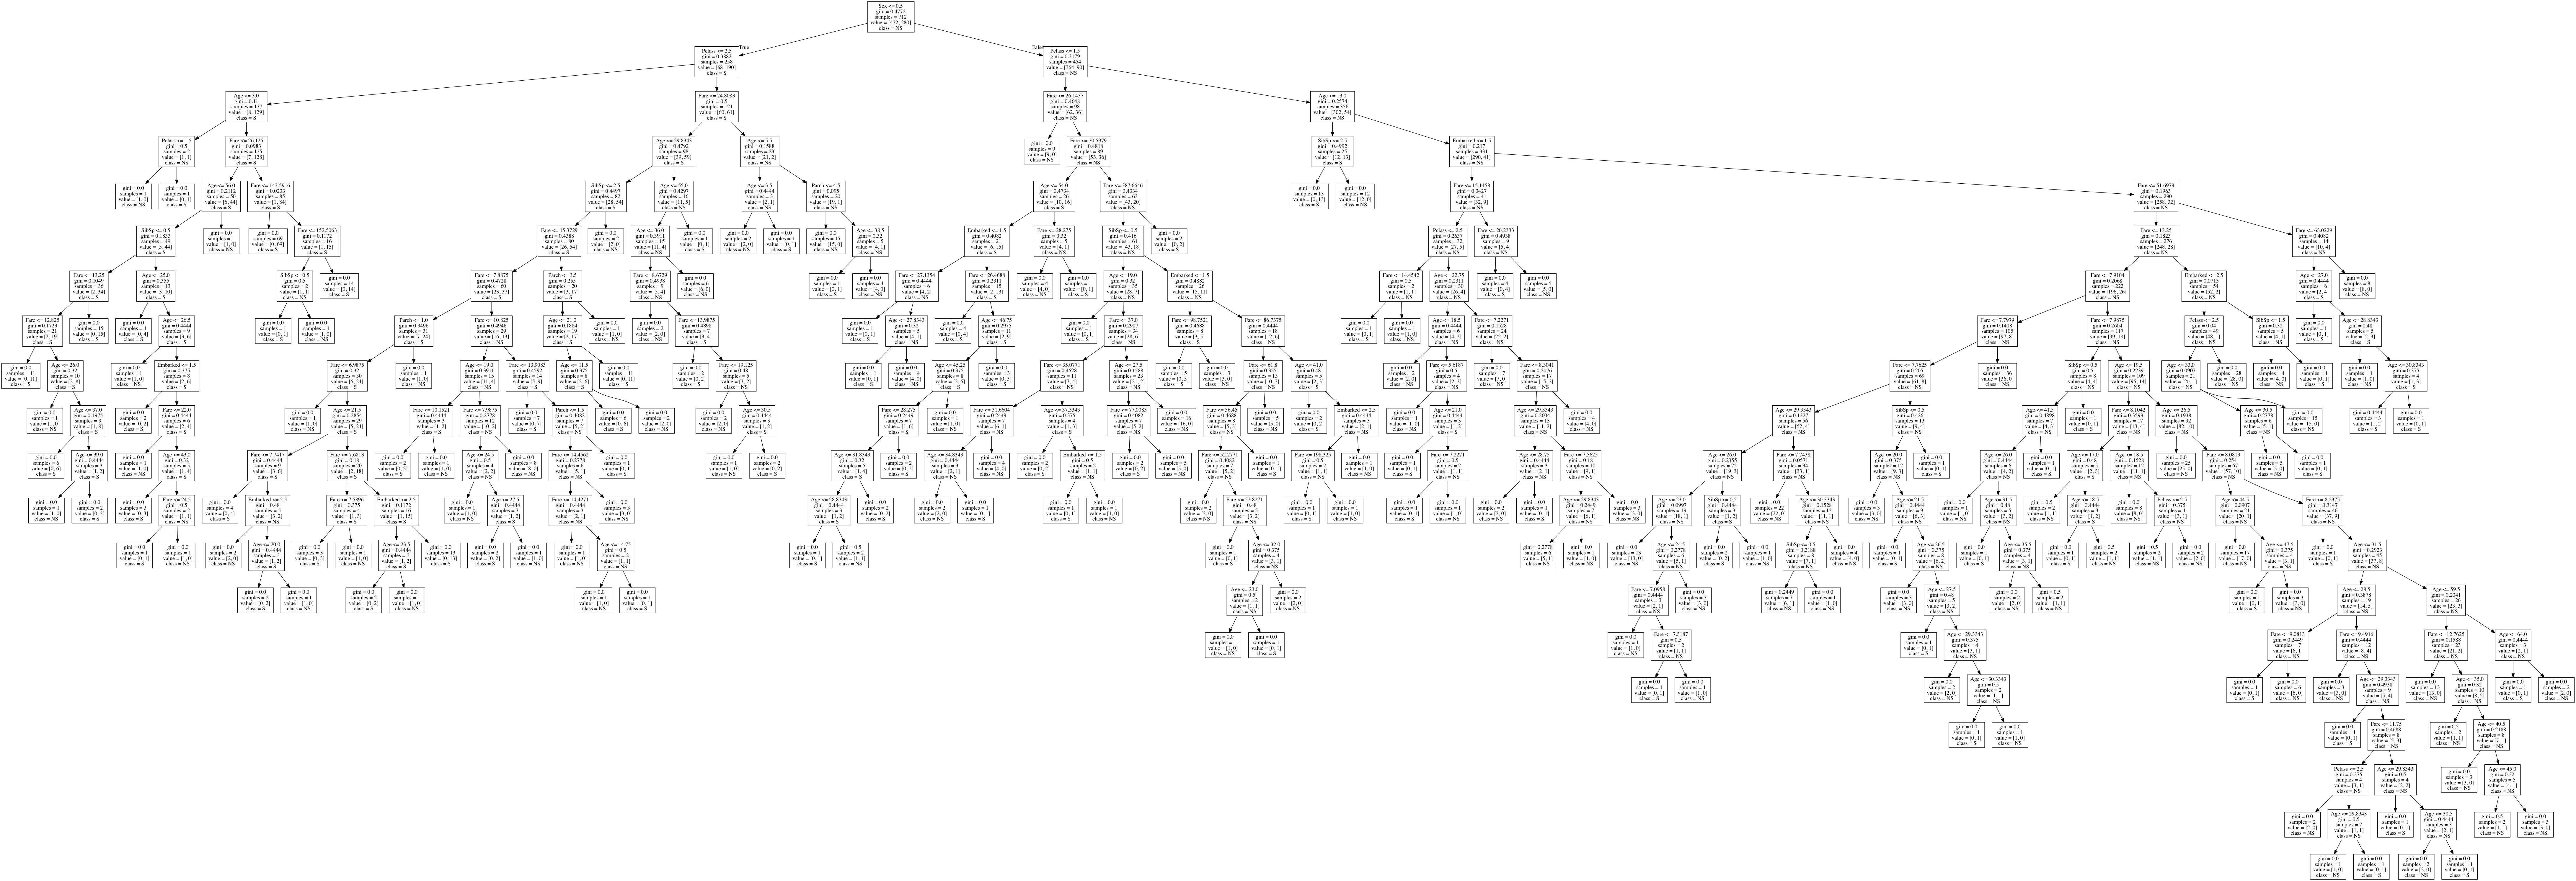

In [24]:
import pydotplus
from IPython.display import Image

def display_decision_tree(classifier):
    dot_data = tree.export_graphviz(classifier, out_file=None,
                                    feature_names=x_train.columns.tolist(),
                                    class_names=['NS', 'S'])
    graph = pydotplus.graph_from_dot_data(dot_data) 
    return Image(graph.create_png())

display_decision_tree(model)

### How does this work?

Decision Trees are greedy classifiers. At every step, they maximize the information gain from separating two sets of data.

<img src="http://image.slidesharecdn.com/lecture08decisiontreesknn-140930094615-phpapp02/95/lecture-8-decision-trees-knearest-neighbors-7-638.jpg?cb=1412071075">

- http://www.slideshare.net/marinasantini1/lecture-8-39706324
- Lecture on Decision Trees: https://www.youtube.com/watch?v=-dCtJjlEEgM

### Making predictions
First we need to transform the validation data the same way we transformed our training data.

In [25]:
x_val.head()

PassengerId  Pclass                            Name     Sex   Age  SibSp  \
27            28       1  Fortune, Mr. Charles Alexander    male  19.0      3   
612          613       3     Murphy, Miss. Margaret Jane  female   NaN      1   
538          539       3        Risien, Mr. Samuel Beard    male   NaN      0   
838          839       3                 Chip, Mr. Chang    male  32.0      0   
782          783       1          Long, Mr. Milton Clyde    male  29.0      0   

     Parch  Ticket      Fare        Cabin Embarked  
27       2   19950  263.0000  C23 C25 C27        S  
612      0  367230   15.5000          NaN        Q  
538      0  364498   14.5000          NaN        S  
838      0    1601   56.4958          NaN        S  
782      0  113501   30.0000           D6        S

In [26]:
x_val = x_val.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)

x_val['Age'] = x_val['Age'].fillna(x_val['Age'].mean())

x_val['Sex'] = x_val['Sex'].map({'female': 0, 'male':1})

x_val['Embarked'] = x_val['Embarked'].map({'C':1, 'S':2, 'Q':3})

x_val.head()

Pclass  Sex        Age  SibSp  Parch      Fare  Embarked
27        1    1  19.000000      3      2  263.0000         2
612       3    0  30.464789      1      0   15.5000         3
538       3    1  30.464789      0      0   14.5000         2
838       3    1  32.000000      0      0   56.4958         2
782       1    1  29.000000      0      0   30.0000         2

Now we use the predict method to feed our validation data into the decision tree to get the predicted target values.

In [27]:
y_prediction = model.predict(x_val)

In [28]:
y_prediction

array([1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0])

Now we compare the predicted validation target labels to the actual validation target labels.

In [29]:
np.sum(y_prediction == y_val) / float(len(y_val))

0.7865168539325843

In [30]:
model.score(x_val, y_val)

0.7865168539325843

### Model Complexity

When we specify a model to describe the data, we need to specify a series of parameters.

In the example above, we specified `None` as the depth of the Decision Tree. This means we place no limits on the depth of the tree.

What happens if we reduce the depth of the tree to 1? 5? 20?

0.808988764045


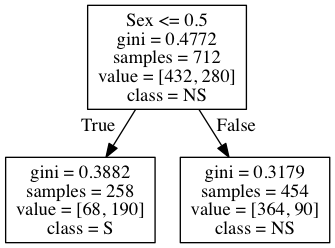

In [31]:
model_1 = tree.DecisionTreeClassifier(max_depth=1, random_state=1)

model_1 = model_1.fit(x_train, y_train)

print(model_1.score(x_val, y_val))
display_decision_tree(model_1)

0.820224719101


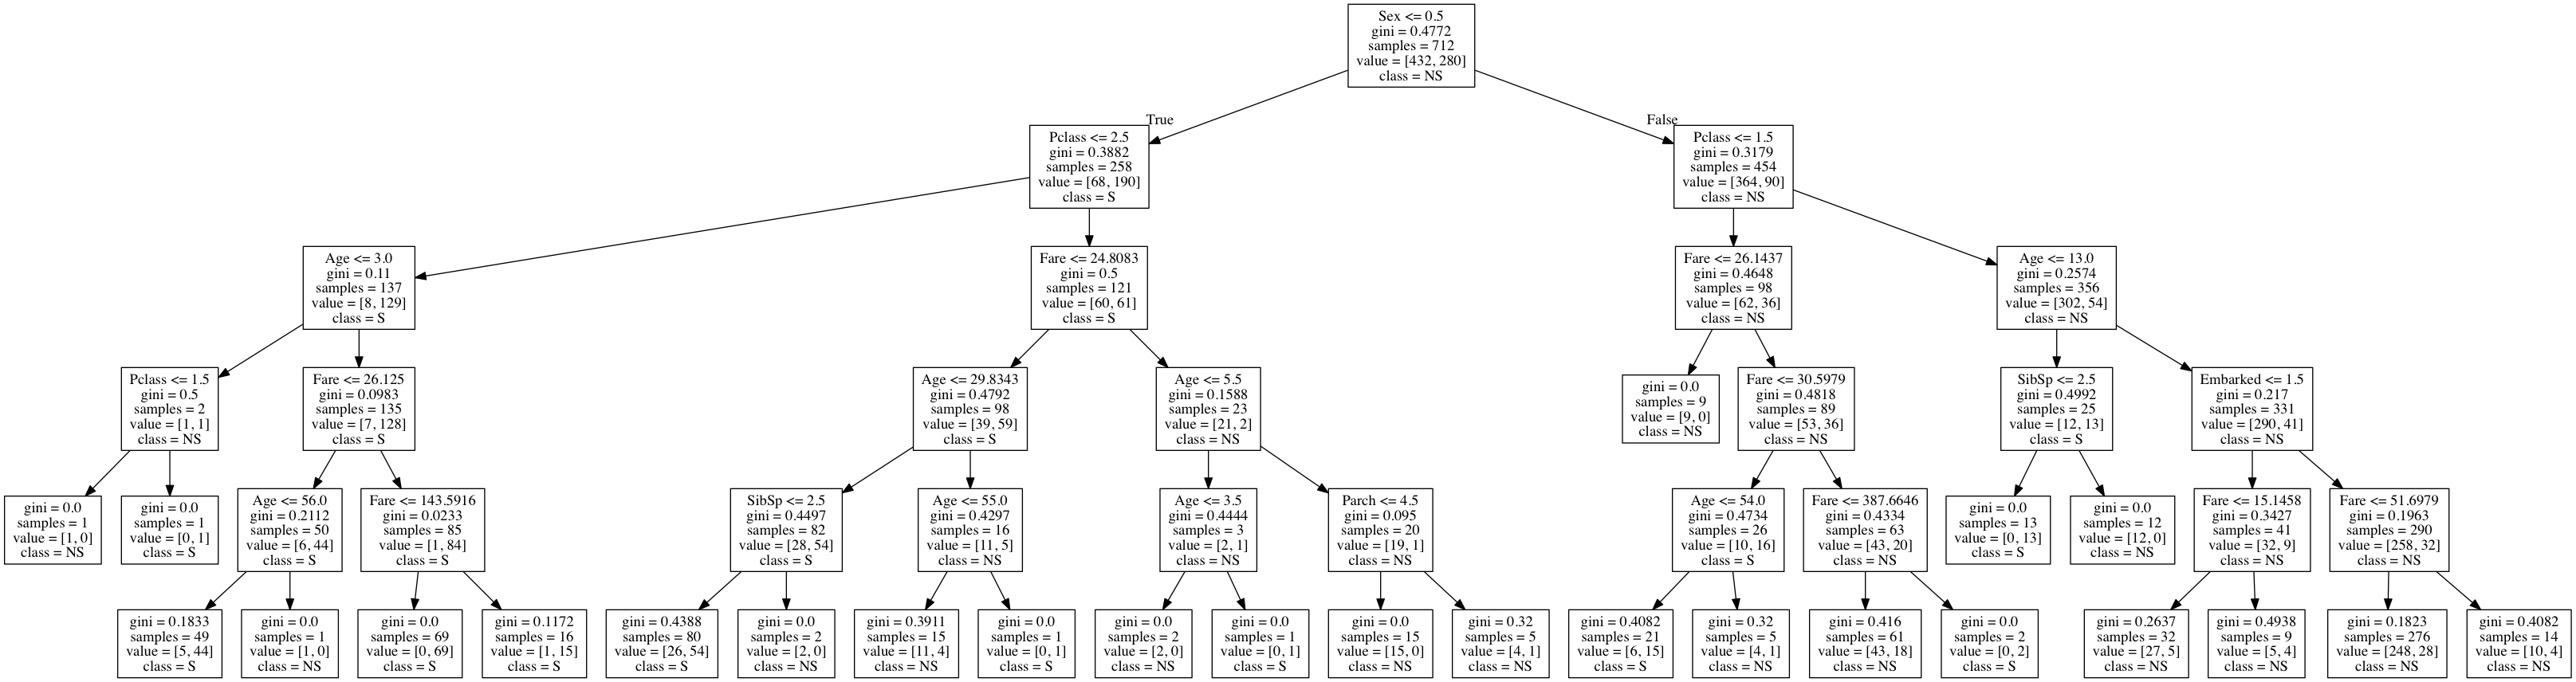

In [32]:
model_5 = tree.DecisionTreeClassifier(max_depth=5, random_state=1)

model_5 = model_5.fit(x_train, y_train)

print(model_5.score(x_val, y_val))
display_decision_tree(model_5)

0.786516853933


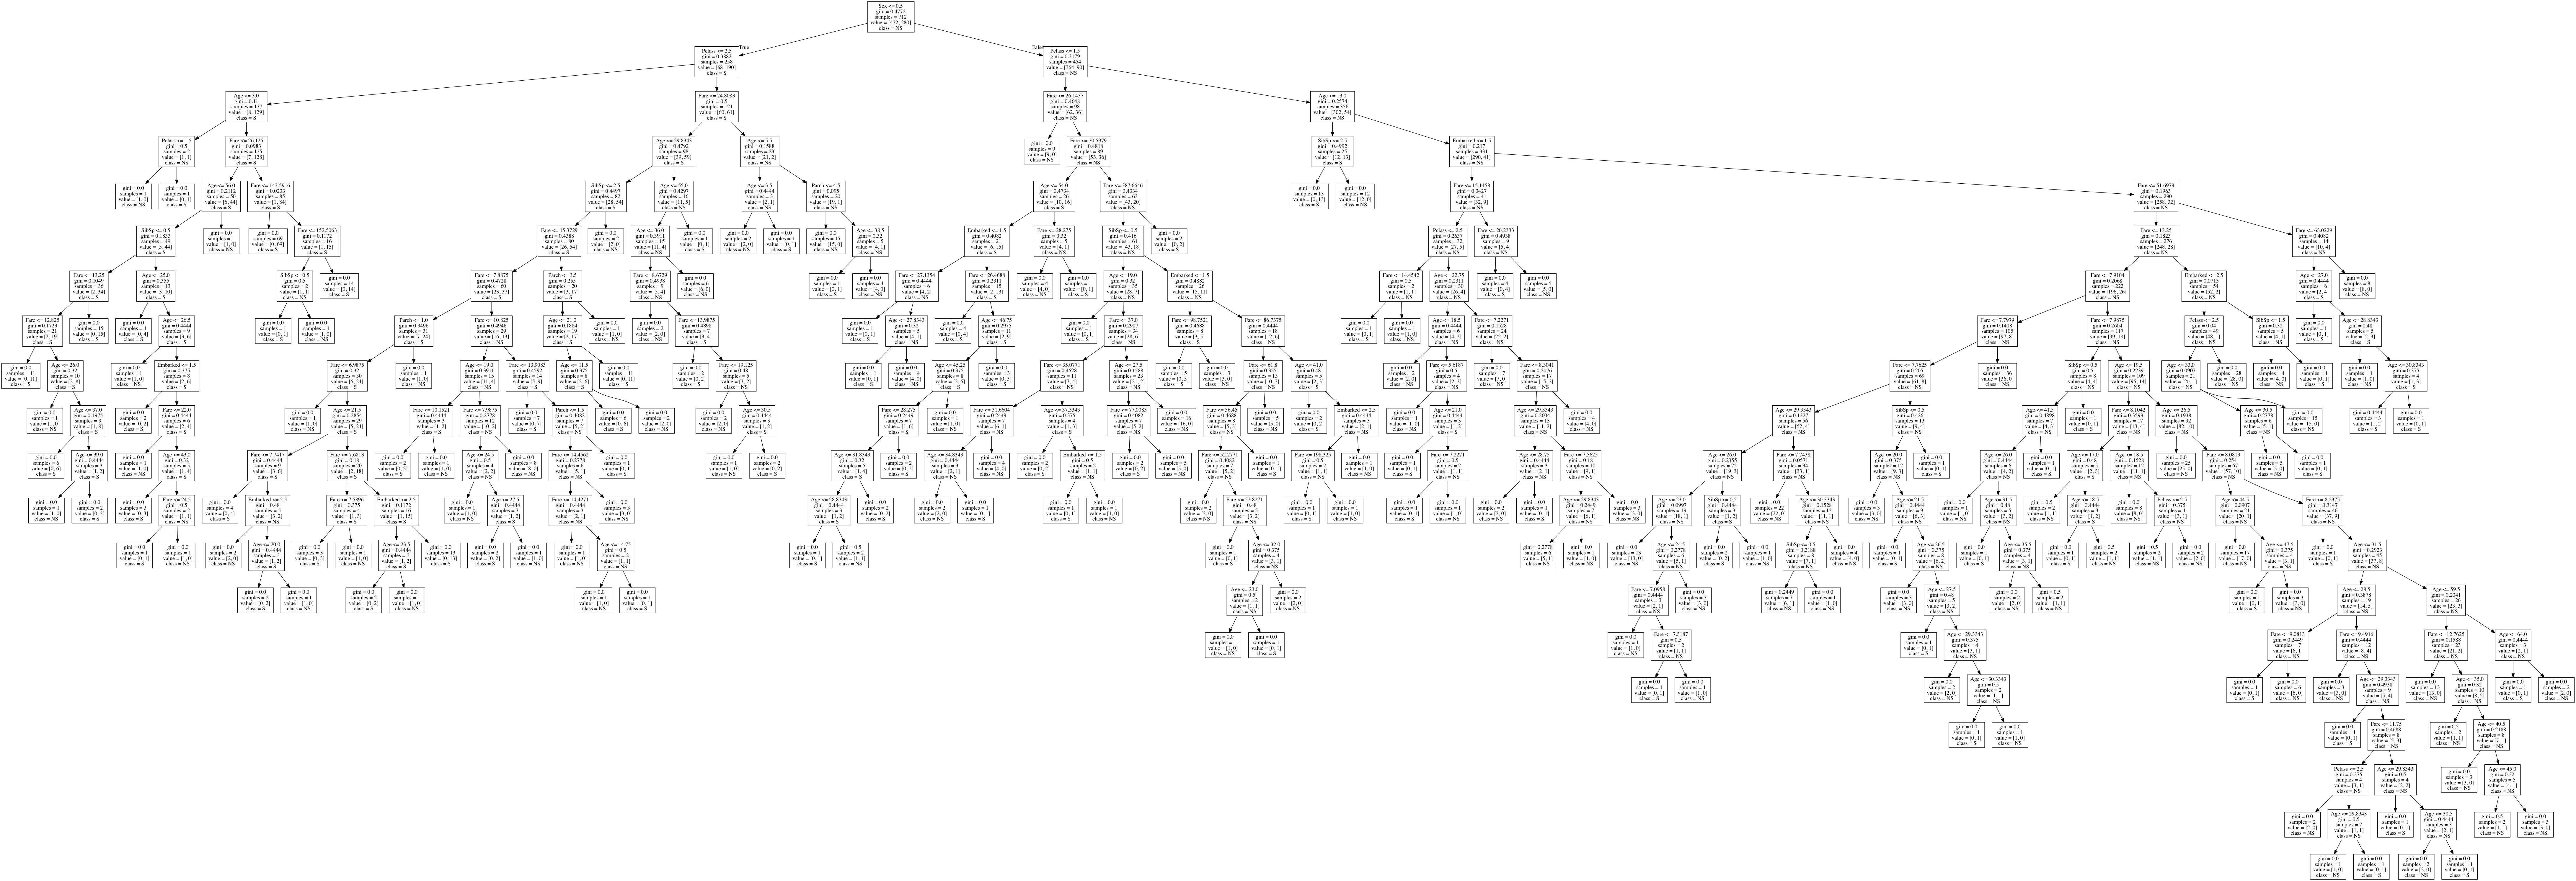

In [33]:
model_20 = tree.DecisionTreeClassifier(max_depth=20, random_state=1)

model_20 = model_20.fit(x_train, y_train)

print(model_20.score(x_val, y_val))
display_decision_tree(model_20)

In [34]:
results = []
for depth in range(1,20):
    clf = tree.DecisionTreeClassifier(max_depth=depth, random_state=1)
    clf = clf.fit(x_train, y_train)
    
    train_score = clf.score(x_train, y_train)
    
    validation_score = clf.score(x_val, y_val)
    
    results.append((train_score, validation_score))

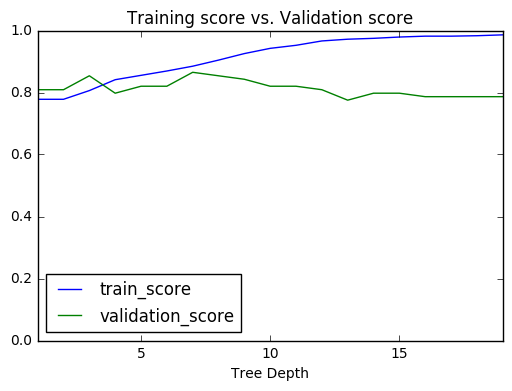

In [35]:
df = pd.DataFrame(results, columns=['train_score', 'validation_score'], index=range(1,len(results)+1))
df.index.name = 'Tree Depth'
df.plot(ylim=[0,1], title='Training score vs. Validation score')

Limiting the depth of the decision tree helps us to avoid overfitting.